# Part II - Which Factors affect Loan Status?
## by Gorata Malose


## Investigation Overview

> In this investigation, I will be studying variables influencing loan status, such as DebtToIncomeRatio, BorrowerRate, IncomeRange and EmploymentStatus. I will also look at the variable Recommendations, which might not have a direct influence on loan status, but can be used to predict whether a borrower will clear their outstanding loans.

## Dataset Overview

> There are 113, 937 loan listings in the dataset, with 81 features. The dataset is too large, so I created a dataframe with only 32 columns, which include variables of interest, related variables, and identifier variables. Most variables are numeric, but variables such as LoanStatus, Occupation and EmploymentStatus are nominal categoricals while IncomeRange is an ordinal categorical variable.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe and filter down to save variables as in the exploratory phase
df = pd.read_csv('prosperLoanData.csv')
loan = df[['ListingKey', 'ListingNumber', 'ListingCreationDate', 'CreditGrade','Term', 'ClosedDate', 'LoanStatus', 'BorrowerAPR',
          'BorrowerRate', 'ProsperRating (numeric)','ProsperRating (Alpha)','ProsperScore','ListingCategory (numeric)', 
          'BorrowerState', 'Occupation', 'EmploymentStatus','EmploymentStatusDuration','CreditScoreRangeLower',
          'CreditScoreRangeUpper','DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable', 'StatedMonthlyIncome', 
          'LoanKey', 'TotalProsperLoans', 'LoanNumber', 'LoanOriginalAmount', 'LoanOriginationDate', 'MemberKey', 
           'MonthlyLoanPayment', 'Recommendations','Investors']].copy()

In [3]:
# Convert IncomeRange into ordered categorical type
ordinal_var_dict = {'IncomeRange': ['Not displayed', 'Not employed', '$0', '$1-24,999', '$25,000-49,999', '$50,000-74,999', 
                                    '$75,000-99,999', '$100,000+']}

ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict['IncomeRange'])

loan['IncomeRange'] = loan['IncomeRange'].astype(ordered_var)

In [4]:
#Combine all past due bins, then FinalPaymentInProgress with Current, and then charged-off with cancelled

past_due = ['Past Due (1-15 days)','Past Due (16-30 days)', 'Past Due (31-60 days)',
            'Past Due (61-90 days)','Past Due (91-120 days)','Past Due (>120 days)']

for status in loan['LoanStatus']:
    if status in past_due:
        loan['LoanStatus'] = loan['LoanStatus'].replace([status], 'Past Due')
    elif status == 'FinalPaymentInProgress':
        loan['LoanStatus'] = loan['LoanStatus'].replace([status], 'Current')
    elif status == 'Chargedoff':
        loan['LoanStatus'] = loan['LoanStatus'].replace([status], 'Cancelled')

In [5]:
#Combine employed, full-time, self-employed and parttime
loan['EmploymentStatus'] = loan['EmploymentStatus'].replace(['Full-time','Self-employed','Part-time'],'Employed')

In [6]:
#drop null values and combine Not Displayed and Not Employed
loan = loan.loc[~loan.EmploymentStatus.isnull()]
loan['IncomeRange'] = loan['IncomeRange'].replace(['Not employed'], 'Not displayed')

In [7]:
#Drop outliers for DebtToIncome ratio
high_outliers = (loan['DebtToIncomeRatio'] > 1)
loan = loan.loc[-high_outliers,:]

In [8]:
# Drop listings with BorrowerRate < 0.04 and CreditScoreRangeLower < 660
low_credit_score = ((loan['BorrowerRate'] < 0.04) & (loan['CreditScoreRangeLower'] <660))
loan = loan.loc[-low_credit_score,:]

## Distribution of Loan Statuses

Most borrowers either have Completed or Current loan statuses.

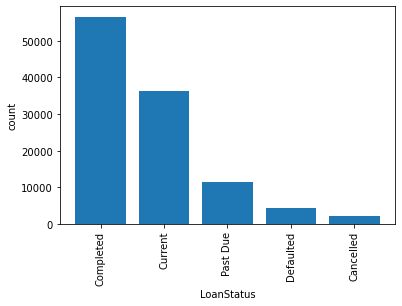

In [9]:
# Return the Series having unique values
x2 = loan['LoanStatus'].unique()
y2 = loan['LoanStatus'].value_counts()

# Create function for plotting bar chart
def LoanStatusDist(x2, y2, **kwargs):
    plt.bar(x2, y2)
    plt.xlabel('LoanStatus')
    plt.ylabel('count')
    plt.xticks(rotation=90)
    plt.show()
    
LoanStatusDist(x2, y2)

## Distribution of Debt to Income Ratios
The histogram is skewed to the right, despite some odd gaps and peaks, and has a general smooth slope after removing extreme ouliers. Most borrowers have a DtI of around 0.2, which is an acceptable value. Anything over 0.5 is not acceptable for DtI.

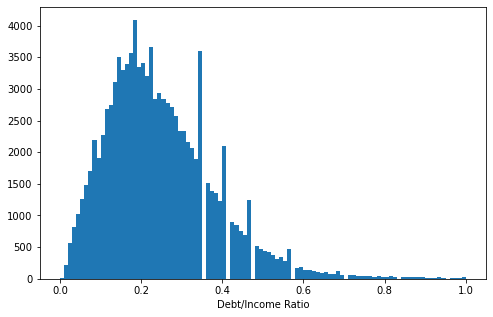

In [11]:
binsize = 0.01

def dtiDist(binsize, **kwargs):
    bins = np.arange(0, loan['DebtToIncomeRatio'].max()+binsize, binsize)
    plt.figure(figsize=[8, 5])
    plt.hist(data = loan, x = 'DebtToIncomeRatio', bins = bins)
    plt.xlabel('Debt/Income Ratio')
    plt.show()
    
dtiDist(binsize)

## Distribution of Borrower Rates
The distribution is generally right skewed, with some peaks to the right, making it multimodal. After dropping low outliers, there are still some very low borrower rates, which are legitimate, given factors like lower risk and higher credit score that make a borrower liekly to receive lower interest rates.


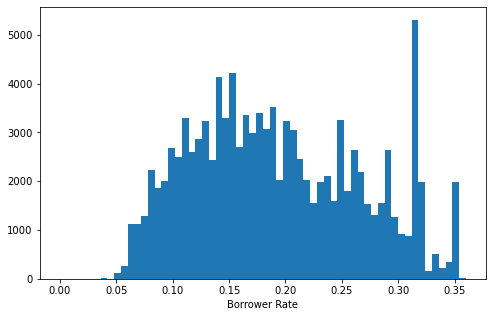

In [12]:
binsize = 0.006

def BorrowerRateDist(binsize, **kwargs):
    bins = np.arange(0, loan['BorrowerRate'].max()+binsize, binsize)
    plt.figure(figsize=[8, 5])
    plt.hist(data = loan, x = 'BorrowerRate', bins = bins)
    plt.xlabel('Borrower Rate')
    plt.show()
    
BorrowerRateDist(binsize)

## Relationship between Loan Status and Income Range, and then Employment Status
Borrowers who are employed and higher income are more likely to be in the Complete or Current loan status.

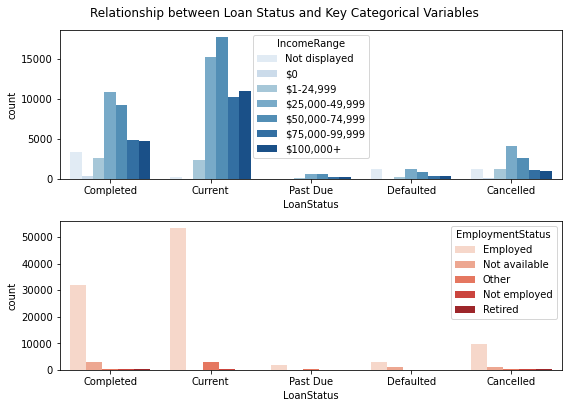

In [13]:
plt.figure(figsize = [8, 8])

# subplot 1: Loan Status vs Income Range
plt.subplot(3, 1, 1)
sb.countplot(data = loan, x = 'LoanStatus', hue = 'IncomeRange', palette = 'Blues')

# subplot 2: Loan Status vs Employment Status
ax = plt.subplot(3, 1, 2)
sb.countplot(data = loan, x = 'LoanStatus', hue = 'EmploymentStatus', palette = 'Reds')

plt.suptitle('Relationship between Loan Status and Key Categorical Variables')
plt.tight_layout()
plt.show()

## Relationship between Loan Status and Recommendations
1. The Recommendation distributions for LoanStatus are all thin slices at similar levels as the values are concentrated around 0 to 1. However, high outliers, are concentrated at Completed, showing that listings with more recommendations are more likely to have their loans cleared, making Recommendations a good predictor of LoanStatus.

2. One thing to note though is that Cancelled status has a higher concentration of outliers than Current. This needs further exploration outside this project as we don't know the different reasons why some loan listings were cancelled.

Text(0.5, 1.0, 'Relationship between Loan Status and Recommendations')

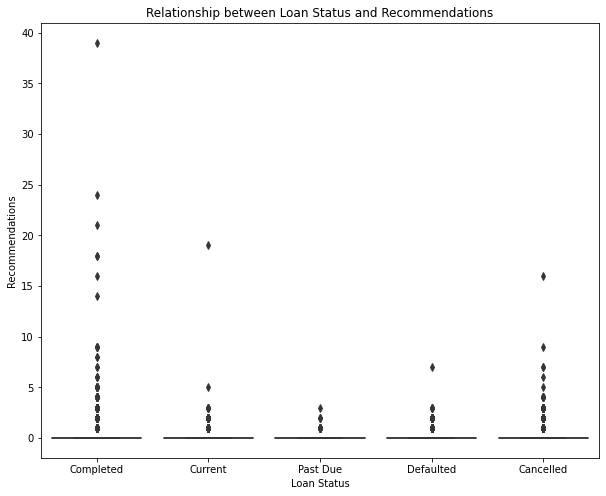

In [14]:
plt.figure(figsize=(10,8))
sb.boxplot(data=loan, x='LoanStatus', y='Recommendations', palette='Blues')

plt.xlabel('Loan Status')
plt.title('Relationship between Loan Status and Recommendations')

## Relationship between Loan Status, Debt to Income Ratio and Borrower Rate.
There is a positive relationship between DtI and BorrowerRate, and Current and Completed LoanStatus have a concentration of values around the lower regions of both numeric variables, showing that borrowers with healthy (lower) DtI and lower borrower rates are more likely to clear their loans.

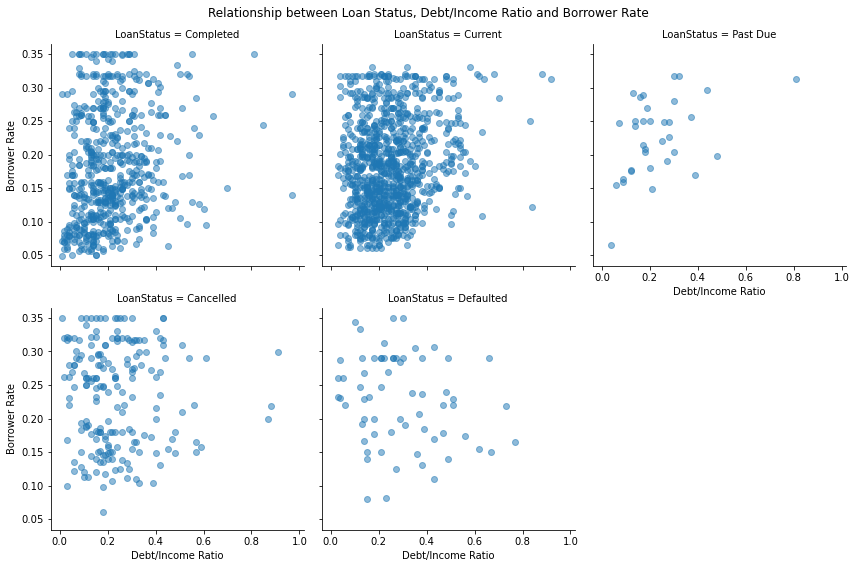

In [15]:
loan_samp = loan.sample(n=2000, replace = False)
g = sb.FacetGrid(data = loan_samp, col = 'LoanStatus', 
                  height=4, margin_titles=True, col_wrap = 3) # height sets the chart size
g.map(plt.scatter, 'DebtToIncomeRatio', 'BorrowerRate', alpha = 1/2)
g.set_xlabels('Debt/Income Ratio')
g.set_ylabels('Borrower Rate')
g.fig.suptitle('Relationship between Loan Status, Debt/Income Ratio and Borrower Rate')

plt.tight_layout()

In [ ]:
!jupyter nbconvert ProsperLoan_Part_II_slide_deck.ipynb --to slides --post serve --no-input --no-prompt